In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
from scipy.stats import kstest, mannwhitneyu
import itertools
# import shap

from tqdm import tqdm

import matplotlib.pyplot as plt
import pingouin as pg
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# file_path = "C:/Users/shrra/Downloads/MASH biomarkers clinical data.csv"
file_path = "C:/Users/shrra/Downloads/MASH_biomarkers_clinicaldata_notimputed_May30_HH.csv"

df = pd.read_csv(file_path)
print(df.columns)

df['MASH'] = df['MASH'].map({'MASH': 1, 'non-MASH': 0})



Index(['ID', 'MASH', 'Age (yrs.)', 'Female n(%)', 'Hispanic race/ethnicity',
       'BMI (kg/m2)', 'BMI z-score', 'WC (cm)', 'ALT (U/L)', 'AST (U/L)',
       'GGT (U/L)', 'Glucose (mg/dL)', 'Insulin (uU/mL)', 'HOMA-IR',
       'TG:HDL ratio', 'TG (mg/dL)', 'TC (mg/dL)', 'LDL-c (mg/dL)',
       'HDL-c (mg/dL)', 'Bilirubin (mg/dL)', 'Creatinine (mg/dL)',
       'Albumin (g/dL)', 'Alk phos (U/L)', 'Uric acid (mg/dL)',
       'Platelet count', 'SBP', 'DBP'],
      dtype='object')


In [26]:
excluded_cols = ["ID", "MASH"]
without_meadian_df = pd.read_csv(file_path)
with_meadian_df = pd.read_csv(file_path)

## just for new 28 may csv

without_meadian_df['MASH'] = without_meadian_df['MASH'].map({'MASH': 1, 'non-MASH': 0})
with_meadian_df['MASH'] = with_meadian_df['MASH'].map({'MASH': 1, 'non-MASH': 0})

##


medians = with_meadian_df.loc[:, with_meadian_df.columns != 'ID'].median()
with_meadian_df  = with_meadian_df.fillna(medians)

In [4]:
KSTest_df = without_meadian_df


excluded_cols = ["ID"]
KSTest_df= KSTest_df.drop(columns=excluded_cols)


print(KSTest_df.columns)

Index(['MASH', 'Age (yrs.)', 'Female n(%)', 'Hispanic race/ethnicity',
       'BMI (kg/m2)', 'BMI z-score', 'WC (cm)', 'ALT (U/L)', 'AST (U/L)',
       'GGT (U/L)', 'Glucose (mg/dL)', 'Insulin (uU/mL)', 'HOMA-IR',
       'TG:HDL ratio', 'TG (mg/dL)', 'TC (mg/dL)', 'LDL-c (mg/dL)',
       'HDL-c (mg/dL)', 'Bilirubin (mg/dL)', 'Creatinine (mg/dL)',
       'Albumin (g/dL)', 'Alk phos (U/L)', 'Uric acid (mg/dL)',
       'Platelet count', 'SBP', 'DBP'],
      dtype='object')


In [7]:

import pandas as pd
from scipy.stats import kstest, mannwhitneyu

def perform_ks_test_ranking(KSTest_df):
    target_column = 'MASH'
    feature_importance = []

    for col in KSTest_df.columns:
        if col != target_column:
            Controls = KSTest_df[KSTest_df[target_column] == 0][col].dropna()
            MASH = KSTest_df[KSTest_df[target_column] == 1][col].dropna()

            ks_stat, ks_p_value = kstest(MASH, Controls)
            U_stat, U_p_value = mannwhitneyu(MASH, Controls)
            U_stat_norm = U_stat / (len(MASH) * len(Controls))
            
            feature_importance.append((col, ks_stat, ks_p_value))
            
            
            print(f'Column: {col}')
            print(f'    KS Stat: {ks_stat}')
            print(f'    KS p-value: {ks_p_value}')
            print(f'    KS Significant? {ks_p_value < 0.05}\n')
            print(f'    MannWhitU Stat Normalized: {U_stat_norm}')
            print(f'    MannWhitU p-value: {U_p_value}')
            print(f'    MannWhitU Significant? {U_p_value < 0.05}\n')

            # Plotting
            # plt.hist(Controls, bins=30, alpha=0.5, color='blue', label='Control')
            # plt.hist(MASH, bins=30, alpha=0.5, color='red', label='MASH')
            # plt.xlabel(f'{col}')
            # plt.ylabel('Frequency')
            # plt.title(f'Histogram of {col}: Controls vs. MASH')
            # plt.legend()
            # plt.axvline(np.median(Controls), color='blue', linestyle='--', label='Control Median')
            # plt.axvline(np.median(MASH), color='red', linestyle='--', label='MASH Median')
            # plt.show()

    # Sorting features by KS statistic in descending order
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    # Print or return sorted list
    for feature in feature_importance:
        print(f'Feature: {feature[0]}, KS Stat: {feature[1]}, KS p-value: {feature[2]}')

    # Create ranking dataframe
    ranking_df = pd.DataFrame(feature_importance, columns=['Feature', 'KS Stat', 'KS p-value'])
    # Sort ranking dataframe by p-value in ascending order
    ranking_df.sort_values(by='KS p-value', inplace=True)
    ranking_df.reset_index(drop=True, inplace=True)

    return feature_importance, ranking_df

# Call the function and also get the ranking dataframe
feature_importance, ranking_df = perform_ks_test_ranking(KSTest_df)

# Print the ranking dataframe
print("\nRanking DataFrame (Ascending Order based on p-value):\n", ranking_df)

Column: Age (yrs.)
    KS Stat: 0.12118603538976566
    KS p-value: 0.027149228589813917
    KS Significant? True

    MannWhitU Stat Normalized: 0.4418758967001435
    MannWhitU p-value: 0.01571035090734711
    MannWhitU Significant? True

Column: Female n(%)
    KS Stat: 0.1935915829746533
    KS p-value: 3.636718523715202e-05
    KS Significant? True

    MannWhitU Stat Normalized: 0.40320420851267336
    MannWhitU p-value: 3.0169755579630005e-06
    MannWhitU Significant? True

Column: Hispanic race/ethnicity
    KS Stat: 0.07113821138211382
    KS p-value: 0.4394909215018186
    KS Significant? False

    MannWhitU Stat Normalized: 0.5355691056910569
    MannWhitU p-value: 0.058598069049424245
    MannWhitU Significant? False

Column: BMI (kg/m2)
    KS Stat: 0.09184600669536107
    KS p-value: 0.16630885923605485
    KS Significant? False

    MannWhitU Stat Normalized: 0.5448708751793401
    MannWhitU p-value: 0.06357100993966645
    MannWhitU Significant? False

Column: BMI z-s

In [8]:
print(ranking_df.columns)
# whether p-value is less than 0.05
ranking_df['pvalueless'] = ranking_df['KS p-value'] < 0.05

ranking_df['pvalueless'] = ranking_df['pvalueless'].map({True: 'Yes', False: 'No'})


print("\nRanking DataFrame with pvalueless Column:\n", ranking_df)

Index(['Feature', 'KS Stat', 'KS p-value'], dtype='object')

Ranking DataFrame with pvalueless Column:
                     Feature   KS Stat    KS p-value pvalueless
0                 AST (U/L)  0.418067  7.588344e-23        Yes
1                 ALT (U/L)  0.348372  7.556060e-16        Yes
2                 GGT (U/L)  0.313998  4.994646e-12        Yes
3            Platelet count  0.209850  1.437043e-05        Yes
4               Female n(%)  0.193592  3.636719e-05        Yes
5                   HOMA-IR  0.169605  4.753212e-04        Yes
6           Insulin (uU/mL)  0.162358  9.687582e-04        Yes
7            Albumin (g/dL)  0.138044  7.649805e-03        Yes
8               BMI z-score  0.134027  1.049427e-02        Yes
9              TG:HDL ratio  0.127340  1.800544e-02        Yes
10           Alk phos (U/L)  0.122166  2.532671e-02        Yes
11               Age (yrs.)  0.121186  2.714923e-02        Yes
12            HDL-c (mg/dL)  0.113445  4.719329e-02        Yes
13       Creat

In [27]:
data =df
data = data.drop(columns='ID')
data = data.drop(columns='MASH')
print(data.columns)

Index(['Age (yrs.)', 'Female n(%)', 'Hispanic race/ethnicity', 'BMI (kg/m2)',
       'BMI z-score', 'WC (cm)', 'ALT (U/L)', 'AST (U/L)', 'GGT (U/L)',
       'Glucose (mg/dL)', 'Insulin (uU/mL)', 'HOMA-IR', 'TG:HDL ratio',
       'TG (mg/dL)', 'TC (mg/dL)', 'LDL-c (mg/dL)', 'HDL-c (mg/dL)',
       'Bilirubin (mg/dL)', 'Creatinine (mg/dL)', 'Albumin (g/dL)',
       'Alk phos (U/L)', 'Uric acid (mg/dL)', 'Platelet count', 'SBP', 'DBP'],
      dtype='object')


Filtered Correlated Pair: ALT (U/L) and AST (U/L) - Correlation: 0.91
Filtered Correlated Pair: ALT (U/L) and GGT (U/L) - Correlation: 0.50
Filtered Correlated Pair: Age (yrs.) and Alk phos (U/L) - Correlation: 0.62
Filtered Correlated Pair: Age (yrs.) and Creatinine (mg/dL) - Correlation: 0.66
Filtered Correlated Pair: HDL-c (mg/dL) and TG:HDL ratio - Correlation: 0.53
Filtered Correlated Pair: HOMA-IR and Insulin (uU/mL) - Correlation: 0.98
        Feature1            Feature2  Correlation
0      ALT (U/L)           AST (U/L)     0.907017
1      ALT (U/L)           GGT (U/L)     0.501010
2     Age (yrs.)      Alk phos (U/L)     0.623779
3     Age (yrs.)  Creatinine (mg/dL)     0.661760
4  HDL-c (mg/dL)        TG:HDL ratio     0.529652
5        HOMA-IR     Insulin (uU/mL)     0.975727


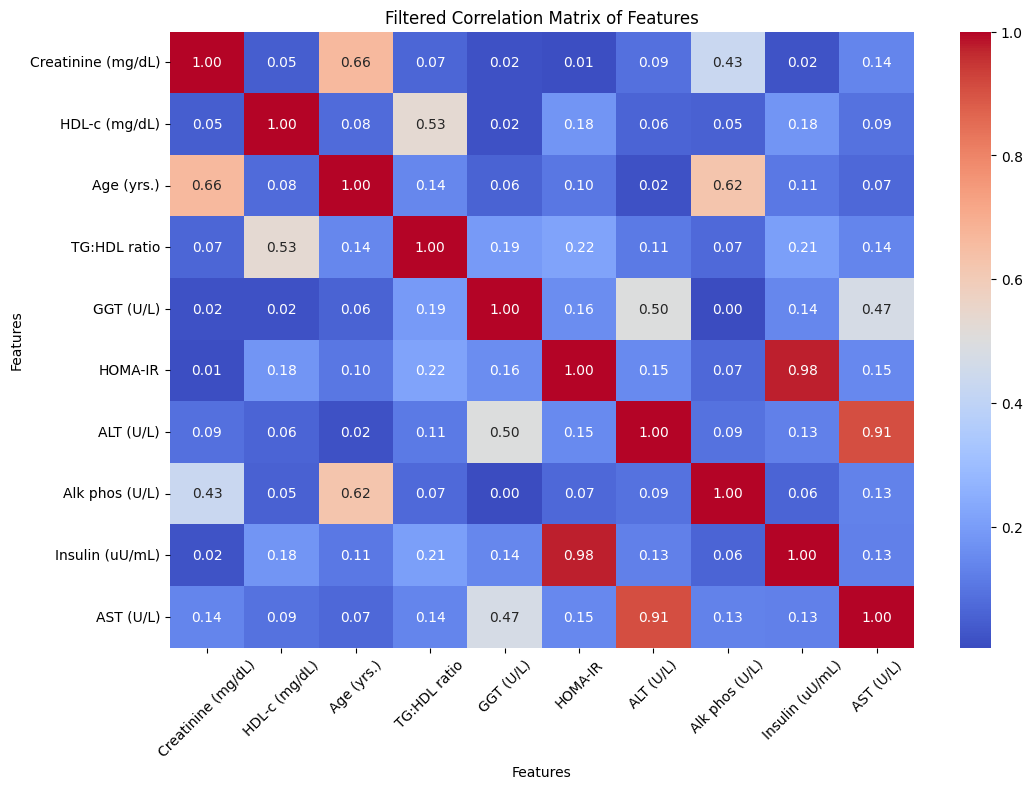

In [12]:
corr_matrix = data.corr().abs()

# Set a threshold for highly correlated features
threshold = 0.5

# Create a mask to identify highly correlated features
mask = (corr_matrix > threshold) & (corr_matrix < 1.0)

# Find indices of feature pairs to remove
indices_to_remove = pd.DataFrame(index=data.columns, columns=data.columns, data=False)
for feature in data.columns:
    indices = corr_matrix.index[mask[feature]]
    indices_to_remove.loc[feature, indices] = True

# Extract groups of highly correlated features
correlated_groups = []
for feature in data.columns:
    correlated_features = indices_to_remove.columns[indices_to_remove.loc[feature]]
    if len(correlated_features) > 0:
        correlated_features = list(correlated_features) + [feature]
        correlated_groups.append(correlated_features)

# Remove duplicate groups and sort for consistency
correlated_groups = [sorted(list(set(group))) for group in correlated_groups]
correlated_groups = sorted(correlated_groups)
correlated_groups = list(group for group, _ in itertools.groupby(correlated_groups))

# Filter groups based on p-value condition
filtered_correlated_groups = []
for group in correlated_groups:
    valid_features = [feature for feature in group if feature in ranking_df[ranking_df['pvalueless'] == 'Yes']['Feature'].values]
    if len(valid_features) > 1:  # Only consider groups with more than one feature
        filtered_correlated_groups.append(valid_features)


group_scores = []
seen_pairs = set()
for group in filtered_correlated_groups:
    for feature in group:
        other_features = [f for f in group if f != feature]
        for other_feature in other_features:
            if corr_matrix.loc[feature, other_feature] > threshold:  # Apply threshold filter
                pair = tuple(sorted((feature, other_feature)))
                if pair not in seen_pairs:
                    seen_pairs.add(pair)
                    score = corr_matrix.loc[feature, other_feature]
                    print(f"Filtered Correlated Pair: {feature} and {other_feature} - Correlation: {score:.2f}")
                    group_scores.append({
                        'Feature1': pair[0],
                        'Feature2': pair[1],
                        'Correlation': score
                    })


group_scores_df = pd.DataFrame(group_scores)
print(group_scores_df)

filtered_features = set()
for group in filtered_correlated_groups:
    filtered_features.update(group)
filtered_features = list(filtered_features) 
filtered_corr_matrix = corr_matrix.loc[filtered_features, filtered_features]

#  heatmap of the filtered correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Filtered Correlation Matrix of Features")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [14]:
group_scores_df.to_csv('C:/Users/shrra/Downloads/MASH_ML/May30 files/MASH_group_corr.csv', index=False)